<a href="https://colab.research.google.com/github/takiyama0617/colaboratory/blob/master/sample_chainer_deep_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#写真データから犬と猫を区別してもらう

In [0]:
import chainer
import cupy

##kaggle-apiからデータセットをダウンロードする
https://github.com/Kaggle/kaggle-api

In [0]:
!pip install kaggle

* Kaggleに登録し、APIキーを取得する
* Googleドライブの任意フォルダーにkaggle.jsonを配置

In [32]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [37]:
!mkdir dogscats
!cd dogscats
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 74.4MB/s]
 99% 537M/543M [00:11<00:00, 45.8MB/s]
100% 543M/543M [00:11<00:00, 48.4MB/s]
 95% 257M/271M [00:03<00:00, 58.6MB/s]
100% 271M/271M [00:03<00:00, 75.4MB/s]


In [38]:
ls

adc.json  dogscats/  sample_data/  sampleSubmission.csv  test1.zip  train.zip


In [0]:
!mv sampleSubmission.csv test1.zip train.zip ./dogscats/

In [42]:
!unzip ./dogscats/test1.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           
  inflating: test1/5520.jpg          
  inflating: test1

In [43]:
!unzip ./dogscats/train.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train

In [0]:
!mv ./test1/ ./dogscats/
!mv ./train/ ./dogscats/

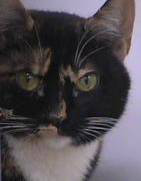

In [53]:
# 学習データを表示してみる
from PIL import Image

train_image_path = './dogscats/train/cat.10091.jpg'
Image.open(train_image_path)

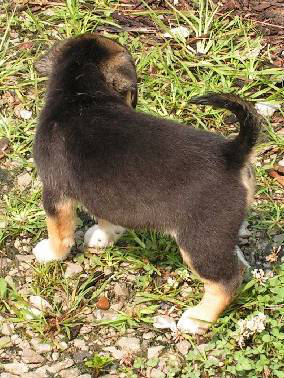

In [54]:
# 検証データを確認してみる
from PIL import Image

valid_image_path  = './dogscats/test1/4248.jpg'
Image.open(valid_image_path)

In [0]:
image_and_teacher_label_list = []

In [0]:
import os

# 犬と猫の画像が正解ラベルと紐づいていない為、セットにする必要がある
# 教師ラベルは、猫：０　犬：１
def get_image_teacher_label_list(dir) :
  filepath_list = []
  files = os.listdir(dir)
  for file in files :
    label = 0
    category = file.split('.')[0]
    if category == 'dog' :
      label = 1
    filepath_list.append((dir + file, label))
  return filepath_list

In [0]:
image_and_teacher_label_list.extend(get_image_teacher_label_list('./dogscats/train/'))

In [81]:
print(image_and_teacher_label_list)

[('./dogscats/train/cat.316.jpg', 0), ('./dogscats/train/cat.247.jpg', 0), ('./dogscats/train/dog.3364.jpg', 1), ('./dogscats/train/dog.6503.jpg', 1), ('./dogscats/train/dog.6482.jpg', 1), ('./dogscats/train/cat.12013.jpg', 0), ('./dogscats/train/dog.4034.jpg', 1), ('./dogscats/train/cat.2101.jpg', 0), ('./dogscats/train/dog.11126.jpg', 1), ('./dogscats/train/dog.4903.jpg', 1), ('./dogscats/train/dog.10449.jpg', 1), ('./dogscats/train/cat.1601.jpg', 0), ('./dogscats/train/dog.8417.jpg', 1), ('./dogscats/train/dog.1143.jpg', 1), ('./dogscats/train/dog.4548.jpg', 1), ('./dogscats/train/cat.11257.jpg', 0), ('./dogscats/train/cat.3578.jpg', 0), ('./dogscats/train/dog.3713.jpg', 1), ('./dogscats/train/cat.251.jpg', 0), ('./dogscats/train/dog.6283.jpg', 1), ('./dogscats/train/cat.5454.jpg', 0), ('./dogscats/train/cat.9812.jpg', 0), ('./dogscats/train/dog.11504.jpg', 1), ('./dogscats/train/cat.4100.jpg', 0), ('./dogscats/train/cat.11729.jpg', 0), ('./dogscats/train/cat.7036.jpg', 0), ('./dogs

## 画像データ形式の整備
ChainerのConvolution2Dなどを使う際には、データ形式を対応したものに整備する必要あり。

In [0]:
import numpy as np

# (x, y, color) => (color, x, y)
def data_reshape(width_height_channel_image) :
  image_array = np.array(width_height_channel_image)
  return image_array.transpose(2, 0, 1)

In [83]:
# 動作確認
import cv2

# 配列形状変換する前の画像データのshape(画像の幅, 高さ, チャンネル)
image_before_reshape = cv2.imread('./dogscats/train/cat.10092.jpg')
print(image_before_reshape.shape)

# 配列形状変換したあとの画像データのshape
image_after_reshape = data_reshape(image_before_reshape)
print(image_after_reshape.shape)

(268, 359, 3)
(3, 268, 359)


### 画像の前処理関数
* 画像のリサイズ
  * 画像サイズがバラバラなので、統一させる
* Image.LANCZOS
  * リサイズ後の画質が良くなるが、処理速度がちょい遅い
* 画像データの変換
  * ChainerのConvolution2Dなどを使う際のデータ形式に対応させる

In [0]:
INPUT_WIDTH = 128
INPUT_HEIGHT = 128

def adapt_data_to_convolution2d_format(input_image) :
  image, label = input_image

  # imageのデータを8ビットの符号なし整数に変換
  image = image.astype(np.uint8)
  # 一回データ構造を戻す(x, y, color)
  image = Image.fromarray(image.transpose(1, 2, 0))
  result_image = image.resize((INPUT_WIDTH, INPUT_HEIGHT), Image.LANCZOS)
  # (x, y, color) => (color, x, y)
  image = data_reshape(result_image)
  # データを0~1の間の値に変換
  image = image.astype(np.float32) / 255
  return image, label

### データセットの作成
教師あり学習なので、画像とラベルをセットにしたデータセットを作成する場合には、LabeledImageDatasetを使うのが最適


In [0]:
from chainer.datasets import LabeledImageDataset

dogscats_dataset = LabeledImageDataset(image_and_teacher_label_list)

* LabeledImageDatasetを使うには、モデルに渡す前に、画像フォーマットを変換する必要がある。
  * 例：RGB画像とグレースケール画像は、同じデータフォーマットに変換しておかないとエラーになる

In [0]:
from chainer.datasets import TransformDataset

transformed_dataset = TransformDataset(dogscats_dataset, adapt_data_to_convolution2d_format)

### 学習データと検証データを分ける
datasets.split_dataset_randomは、データセットをランダムに２つに分けてくれるメソッド
第1引数：分けたい対象のデータセット
第2引数：１つ目のデータセットのサイズ
第３引数：乱数を発生させるシード

In [0]:
from chainer import datasets

train_data, test_data = datasets.split_dataset_random(transformed_dataset, int(len(transformed_dataset) * 0.8), seed=0)

In [91]:
print(int(len(transformed_dataset) * 0.8))
print(len(train_data))
print(len(test_data))

20000
20000
5000


In [92]:
print(train_data)

## 畳み込みニューラルネットワークのモデルを用意

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training, serializers, Chain, optimizers, iterators
from chainer.training import extensions, Trainer

In [0]:
GPU_ID = 0 # GPUを使用しない場合は、「-1」を設定
BATCH_SIZE = 64
MAX_EPOCH = 10

### CNNを設定

In [0]:
class CNN(Chain) :
  def __init__(self) :
    super(CNN, self).__init__()
    with self.init_scope():
      self.conv1 = L.Convolution2D(None, out_channels=32, ksize=3, stride=1, pad=1)
      self.conv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=3, stride=1, pad=1)
      self.conv3 = L.Convolution2D(in_channels=64, out_channels=128, ksize=3, stride=1, pad=1)
      self.conv4 = L.Convolution2D(in_channels=128, out_channels=256, ksize=3, stride=1, pad=1)
      self.layer1 = L.Linear(None, 1000)
      self.layer2 = L.Linear(1000, 2)

  def __call__(self, input) :
    func = F.max_pooling_2d(F.relu(self.conv1(input)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv2(func)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv3(func)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv4(func)), ksize=2, stride=2)
    func = F.dropout(F.relu(self.layer1(func)), ratio=0.80)
    func = self.layer2(func)
    return func

In [118]:
model = L.Classifier(CNN())
model.to_gpu(GPU_ID)

### 反復子の用意
MultiprocessIteratorは、Chainerで事前に定義済みの反復子のテンプレート

In [0]:
# 学習用の反復子
train_iterator = iterators.MultiprocessIterator(train_data, BATCH_SIZE)
# 検証用の反復子
test_iterator = iterators.MultiprocessIterator(test_data, BATCH_SIZE, False, False)

### Optimizerの設定
* 最適化アルゴリズムの選択
  * 最適化：損失関数を最小値になるように更新していく過程
* Adamという最適化アルゴリズムを適用する
  * 損失関数の最適化を行う際に使うoptimizerの一種

In [0]:
optimizer = optimizers.Adam().setup(model)

### updaterの設定
* updaterは、ミニバッチを学習させ、学習結果を持って、ニューラルネットワークを更新する役割
* updaterがiteratorと連携して学習させるのが、標準的な使い方

In [0]:
updater = training.StandardUpdater(train_iterator, optimizer, device=GPU_ID)

### trainerの設定
* trainerもChainerの標準的な使い方で、学習プロセスを反復させ、自動化する

In [0]:
trainer = Trainer(updater, stop_trigger=(MAX_EPOCH, 'epoch'))

### extensionsの設定
* extensionsは、学習過程で呼び出すことが出来るオブジェクトのこと
* 学習の精度や誤差のグラフを出したり、進捗のメッセージを出したり、ログ出力したい時などに設定

In [0]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(test_iterator, model, device=GPU_ID), name='validation')
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']
))

# レポートのグラフを出力するextension
trainer.extend(extensions.PlotReport(
    ['main/loss', 'validation/main/loss'], x_key='epoch', marker='^', grid=True, file_name='loss.png'
))
trainer.extend(extensions.PlotReport(
    ['main/accuracy', 'validation/main/accuracy'], x_key='epoch', marker='^', grid=True, file_name='accuracy.png'
))

### 学習の実行

In [124]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.667677    0.619908       0.606941              0.677611                  136.832       
2           0.531097    0.733974       0.471964              0.77413                   260.771       
3           0.427476    0.801468       0.404777              0.813489                  385.026       
4           0.347862    0.847206       0.324497              0.857793                  511.649       
5           0.282778    0.882638       0.289495              0.874407                  637.93        
6           0.229078    0.904647       0.274992              0.882714                  762.966       
7           0.191134    0.921725       0.262072              0.891218                  889.043       
8           0.158763    0.937099       0.275041              0.89379                   1014.9        
9           0.121814    0.950429       0.289091              0.895965               

### 学習結果の確認

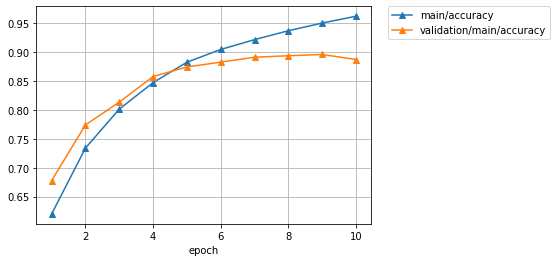

In [126]:
Image.open('result/accuracy.png')

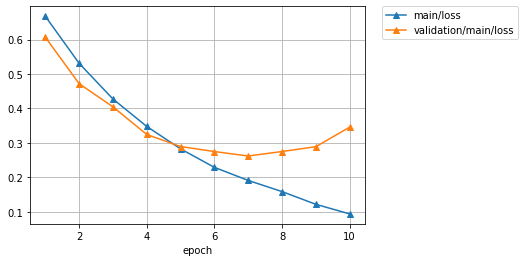

In [127]:
Image.open('result/loss.png')

## 検証（学習済みモデルを使う）

In [128]:
ls

adc.json  data  dogscats/  result/  sample_data/


In [0]:
serializers.save_hdf5('chainer-dogscats-model.h5', model)

In [130]:
ls 

adc.json  chainer-dogscats-model.h5  data  dogscats/  result/  sample_data/


In [0]:
def convert_test_data(image_file_path, size, show=False) :
  image = Image.open(image_file_path)
  # 画像リサイズ
  result_image = image.resize((INPUT_WIDTH, INPUT_HEIGHT), Image.LANCZOS)
  # Chainer.Convolution2Dで使えるように整備
  image = data_reshape(result_image)
  result = image.astype(np.float32)
  # 学習済みモデルに渡す
  result = model.xp.asarray(result)
  # モデルに渡すデータフォーマットに変換
  result = result[None, ...]
  return result

In [133]:
ls dogscats/test1

10000.jpg  11609.jpg  1966.jpg  3573.jpg  5180.jpg  6789.jpg  8396.jpg
10001.jpg  1160.jpg   1967.jpg  3574.jpg  5181.jpg  678.jpg   8397.jpg
10002.jpg  11610.jpg  1968.jpg  3575.jpg  5182.jpg  6790.jpg  8398.jpg
10003.jpg  11611.jpg  1969.jpg  3576.jpg  5183.jpg  6791.jpg  8399.jpg
10004.jpg  11612.jpg  196.jpg   3577.jpg  5184.jpg  6792.jpg  839.jpg
10005.jpg  11613.jpg  1970.jpg  3578.jpg  5185.jpg  6793.jpg  83.jpg
10006.jpg  11614.jpg  1971.jpg  3579.jpg  5186.jpg  6794.jpg  8400.jpg
10007.jpg  11615.jpg  1972.jpg  357.jpg   5187.jpg  6795.jpg  8401.jpg
10008.jpg  11616.jpg  1973.jpg  3580.jpg  5188.jpg  6796.jpg  8402.jpg
10009.jpg  11617.jpg  1974.jpg  3581.jpg  5189.jpg  6797.jpg  8403.jpg
1000.jpg   11618.jpg  1975.jpg  3582.jpg  518.jpg   6798.jpg  8404.jpg
10010.jpg  11619.jpg  1976.jpg  3583.jpg  5190.jpg  6799.jpg  8405.jpg
10011.jpg  1161.jpg   1977.jpg  3584.jpg  5191.jpg  679.jpg   8406.jpg
10012.jpg  11620.jpg  1978.jpg  3585.jpg  5192.jpg  67.jpg    8407.jpg
10013.jpg

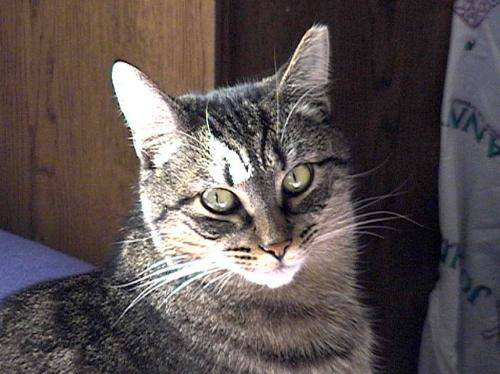

In [139]:
test_image_url = 'dogscats/test1/9951.jpg'

from PIL import Image
import numpy as np

image_path = test_image_url
Image.open(image_path)

In [140]:
from chainer.cuda import to_cpu

# 学習時と同じ画像サイズにしないといけない！c
test_data = convert_test_data(test_image_url, (INPUT_WIDTH, INPUT_HEIGHT))
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False) :
  test_teacher_labels = model.predictor(test_data)
  test_teacher_labels = to_cpu(test_teacher_labels.array)
  test_teacher_label = test_teacher_labels.argmax(axis=1)[0]
  if test_teacher_label == 0:
    retval = '猫'
  else:
    retval = '犬'

print(retval)

猫


### Google Driveに保存する
学習済みモデルは、ファイルサイズが大きいので、GoogleDriveに保存の方が、高速

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 認証とPyDrive クライアントの作成
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
uploaded = drive.CreateFile({'title': 'chainer-dogscats-model.h5'})
uploaded.SetContentFile('chainer-dogscats-model.h5')

In [145]:
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 151n4ujQFULutlENw8ZSQ14zYAmZ7cWX9
